# CH3 Decision Tree

http://en.wikipedia.org/wiki/ID3_algorithm


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Create Dataset

In [2]:
dataSet = pd.DataFrame({'no surfacing':[1,1,1,0,0],'flippers':[1,1,0,1,1],'is Fish':['yes','yes','no','no','no']},columns=["no surfacing","flippers","is Fish"])
dataSet

,no surfacing,flippers,is Fish
0,1,1,yes
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


## ID3

### Metric

#### Entropy

In [3]:
len(dataSet)

5

In [4]:
def calcShannonEnt(dataSet):
    col = dataSet.columns.tolist()[-1]
    prob = dataSet.groupby(by=col).size()/len(dataSet)
    return sum(-np.log2(prob)*prob)    

In [5]:
calcShannonEnt(dataSet)

0.9709505944546686

In [6]:
dataSet["is Fish"].iloc[0] = "maybe"

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
dataSet

,no surfacing,flippers,is Fish
0,1,1,maybe
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [8]:
calcShannonEnt(dataSet)

1.3709505944546687

#### Conditional Entroy

书里少解释了一个点，条件熵(conditional entropy)

$$ H(Y|X)=\sum_{i=1}^{n}p_iH(Y|X=x_i)$$

其中$p_i=P(X=x_i),i=1,2,...,n$

[李航，2012，P61]

### Partition

In [9]:
def splitDataSet(dataSet,axis,value):
    return dataSet[dataSet[axis] == value][dataSet.columns.drop(axis)]

In [10]:
dataSet

,no surfacing,flippers,is Fish
0,1,1,maybe
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [11]:
splitDataSet(dataSet,"flippers",1)

,no surfacing,is Fish
0,1,maybe
1,1,yes
3,0,no
4,0,no


In [12]:
calcShannonEnt(splitDataSet(dataSet,"no surfacing",0))

0.0

In [13]:
calcShannonEnt(splitDataSet(dataSet,"no surfacing",1))

1.584962500721156

In [14]:
calcShannonEnt(splitDataSet(dataSet,"flippers",0))

0.0

In [15]:
calcShannonEnt(splitDataSet(dataSet,"flippers",1))

1.5

### Feature Selection

In [16]:
def chooseBestFeatureToSplit(dataSet):
    feas = dataSet.columns.tolist()[:-1]
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0
    
    for fea in feas:
        newEntropy = 0
        for value in set(dataSet[fea]):
            subSet = splitDataSet(dataSet,fea,value)
            #conditional entropy
            Pi = len(subSet)/len(dataSet)
            newEntropy += Pi*calcShannonEnt(subSet)
    
        infoGain = baseEntropy - newEntropy
        if  (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = fea
    return bestFeature

In [17]:
calcShannonEnt(dataSet)

1.3709505944546687

In [18]:
dataSet.columns

Index(['no surfacing', 'flippers', 'is Fish'], dtype='object')

In [19]:
feas = dataSet.columns.tolist()[:-1]
feas

['no surfacing', 'flippers']

In [20]:
set(dataSet["flippers"])

{0, 1}

In [21]:
chooseBestFeatureToSplit(dataSet)

'no surfacing'

## Tree

### Create Tree

In [22]:
dataSet

,no surfacing,flippers,is Fish
0,1,1,maybe
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [23]:
import operator
def majorityCnt(dataSet):
    label = dataSet.columns.tolist()[-1]
    return sorted(dataSet.groupby(by=label).size().iteritems(),key=operator.itemgetter(1),reverse=True)[0][0]
majorityCnt(dataSet)

'no'

In [24]:
# iteritems
list(dataSet.groupby(by="is Fish").size().iteritems())

[('maybe', 1), ('no', 3), ('yes', 1)]

In [25]:
def createTree(dataSet):
#     print("======")
#     print(dataSet)
    # stop condition
    feas = dataSet.columns.tolist()[:-1]
    label = dataSet[dataSet.columns.tolist()[-1]]
    # entropy == 0
    if len(set(label)) == 1:
#         print("condition 1")
        return list(label)[0]
    # no feature to use
    if len(set(feas)) == 0:
#         print("condition 2")
        return majorityCnt(dataSet)
    bestFeature = chooseBestFeatureToSplit(dataSet)
    myTree = {bestFeature:{}}
    featValues = set(dataSet[bestFeature])
#     print(featValues)
    for value in featValues:
        subDataSet = dataSet[dataSet[bestFeature]==value]
        myTree[bestFeature][value] = createTree(splitDataSet(subDataSet,bestFeature,value))
    return myTree

In [26]:
dataSet

,no surfacing,flippers,is Fish
0,1,1,maybe
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [27]:
myTree = createTree(dataSet)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'maybe'}}}}

### Plot Tree

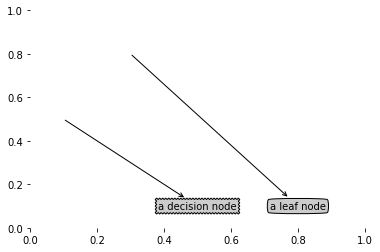

In [28]:
decisionNode = dict(boxstyle="sawtooth",fc="0.8")
leafNode = dict(boxstyle="round4",fc="0.8")
arrow_args= dict(arrowstyle="<-")
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt,
                            xy=parentPt,xycoords="axes fraction",
                            xytext=centerPt,textcoords="axes fraction",
                            va="center",ha="center",bbox=nodeType,arrowprops=arrow_args)
def createPlot():
    fig = plt.figure(1, facecolor="white")
    fig.clf()
    createPlot.ax1 = plt.subplot(111,frameon=False)
    plotNode('a decision node',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode('a leaf node',(0.8,0.1),(0.3,0.8),leafNode)
    plt.show()
createPlot()

In [29]:
myTree.keys()

dict_keys(['no surfacing'])

In [30]:
myTree.items()

dict_items([('no surfacing', {0: 'no', 1: {'flippers': {0: 'no', 1: 'maybe'}}})])

In [31]:
dataSet[dataSet["is Fish"] == "maybe"].index.tolist()

[0]

In [32]:
myTree.values()

dict_values([{0: 'no', 1: {'flippers': {0: 'no', 1: 'maybe'}}}])

In [33]:
labels = ["no surfacing","flippers"]
labels.index("flippers")

1

In [34]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'maybe'}}}}

In [35]:
list(myTree.keys())[0]

'no surfacing'

In [36]:
"flippers" in myTree.keys()

False

In [37]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'maybe'}}}}

In [38]:
def checkNode(nodeIn):
    keys = list(nodeIn.keys())
    for key in keys:
        childNode = nodeIn[key]
        print("key",key)
        if type(childNode).__name__ == 'dict':
            checkNode(childNode)
        else:
            print("leaf:",childNode)

In [39]:
checkNode(myTree)

key no surfacing
key 0
leaf: no
key 1
key flippers
key 0
leaf: no
key 1
leaf: maybe


In [40]:
print(list(myTree.keys())[0])

no surfacing


In [41]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == "dict":
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=="dict":
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

In [42]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid,yMid,txtString)
# 参数命名尽量不要和全局的重合，不方便debug
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
#     print("dict",myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
#     print("second",secondDict)
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
#             print("key",key,"dict",secondDict[key])
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    axprops = dict(xticks=[],yticks=[])
    createPlot.ax1 = plt.subplot(111,frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

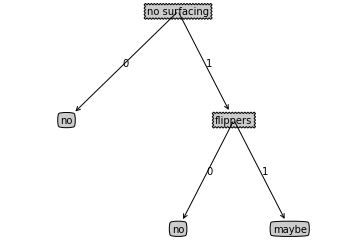

In [43]:
createPlot(myTree)

In [44]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'maybe'}}}}

In [45]:
def tmpfun():
    return tmpfun.test

In [46]:
tmpfun.test = 1
tmpfun()

1

## Classifier

### Classify

In [47]:
def classify(inputTree, featLabels,testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == "dict":
                classLabel = classify(secondDict[key],featLabels,testVec)
            else:
                classLabel = secondDict[key]
    return classLabel       

In [48]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'maybe'}}}}

In [49]:
classify(inputTree=myTree,featLabels=["no surfacing","flippers"],testVec=[1,1])

'maybe'

### Store

In [50]:
def storeTree(inputTree,filename):
    import pickle
    with open(filename,'wb') as f:
        pickle.dump(inputTree,f)
def grabTree(filename):
    import pickle
    with open(filename,'rb') as f:
        return pickle.load(f)

### Lenses

#### Data

In [51]:
lenseData = pd.read_csv("./Data/lenses/lenses.data",
                index_col=0,
                names=["idx","age of the patient","spectacle prescription","astigmatic","tear production rate","type"],
                sep = "\s+")
# note this sep

In [52]:
lenseData.head()

,age of the patient,spectacle prescription,astigmatic,tear production rate,type
idx,,,,,
1,1,1,1,1,3
2,1,1,1,2,2
3,1,1,2,1,3
4,1,1,2,2,1
5,1,2,1,1,3


#### Decision Tree

In [53]:
lenseTree = createTree(lenseData)
lenseTree

{'tear production rate': {1: 3,
  2: {'astigmatic': {1: {'age of the patient': {1: 2,
      2: 2,
      3: {'spectacle prescription': {1: 3, 2: 2}}}},
    2: {'spectacle prescription': {1: 1,
      2: {'age of the patient': {1: 1, 2: 3, 3: 3}}}}}}}}

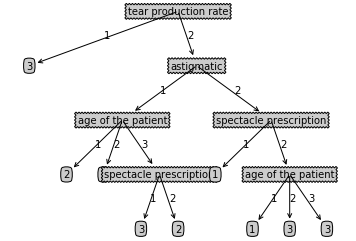

In [54]:
createPlot(lenseTree)